# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
train = pd.read_csv('gold_recovery_train_new.csv', index_col = 'date')
test = pd.read_csv('gold_recovery_test_new.csv', index_col = 'date')
full = pd.read_csv('gold_recovery_full_new.csv', index_col = 'date')
alldata = [train, test, full]

In [3]:
for data in alldata:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

None

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

None

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

None

В нашем распоряжении 3 датафрейма: обучающая выборка, тестовая выборка и исходные данные. Сразу бросается в глаза, что в тестовом датасете только 52 столбца, а в обучающем и общем - 86.  

Посмотрим, каких столбцов нет в тестовом датасете:

In [4]:
columns_missing = set(train.columns) - set(test.columns)
columns_missing

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Итого получается, что отсутствуют 2 колонки с таргетом (rougher.output.recovery и final.output.recovery) и еще 32 признака.

Добавим в тестовый датасет таргеты:

In [5]:
test = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], on='date', how='left')
len(test.columns)

54

Описательная статистика:

In [6]:
for data in alldata:
    display(data.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Посмотрим на дубликаты:

In [7]:
for data in alldata:
    display(data.duplicated().sum())

0

0

0

Проверим, есть ли пропущенные значения:

In [8]:
for data in alldata:
    pd.set_option('display.max_rows', None) 
    display(data.isnull().sum())

final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 286
primary_cleaner.output.concentrate_au                   

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 370
primary_cleaner.output.concentrate_au                   

Пропущенных значений много.

Удалим строчки с пропусками во всех таргетах (full датасет вообще не трогаем):

In [9]:
train = train.dropna(subset=['final.output.recovery'])
train = train.dropna(subset=['rougher.output.recovery'])
test = test.dropna(subset=['final.output.recovery'])
test = test.dropna(subset=['rougher.output.recovery'])

По условию сказано, что соседние по времени параметры часто похожи, поэтому заполним пропуски в признаках на основе соответствующего значения в предыдущей строке (методом ffill):

In [10]:
test = test.fillna(method='ffill')
train = train.fillna(method='ffill')

**Проверим, что эффективность обогащения рассчитана правильно. Вычислим ее на обучающей выборке для признака rougher.output.recovery.**

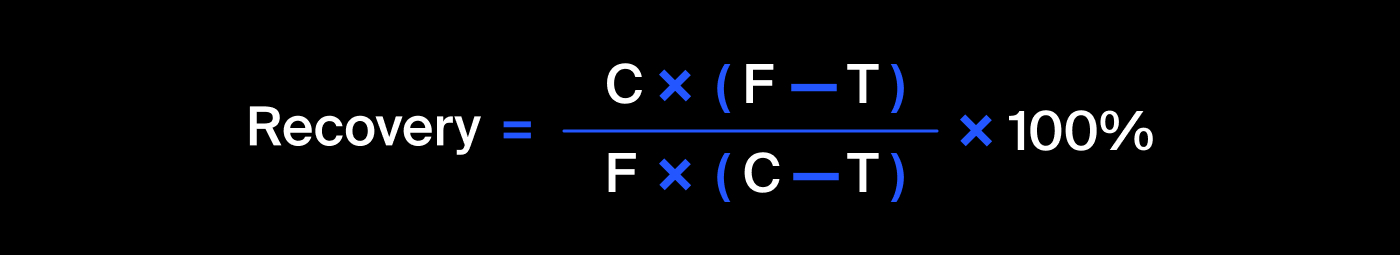

* C — доля золота в концентрате после флотации/очистки; 
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [11]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [12]:
recovery = (C * (F-T)) / (F * (C - T)) * 100
mean_absolute_error(train['rougher.output.recovery'], recovery)

9.73512347450521e-15

MAE стремится к 0, поэтому будем считать, что эффективность обогащения рассчитана верно.

## Анализ данных

**2.1 Распределение концентрации металлов (Au, Ag, Pb) на различных этапах очистки**

*Золото*

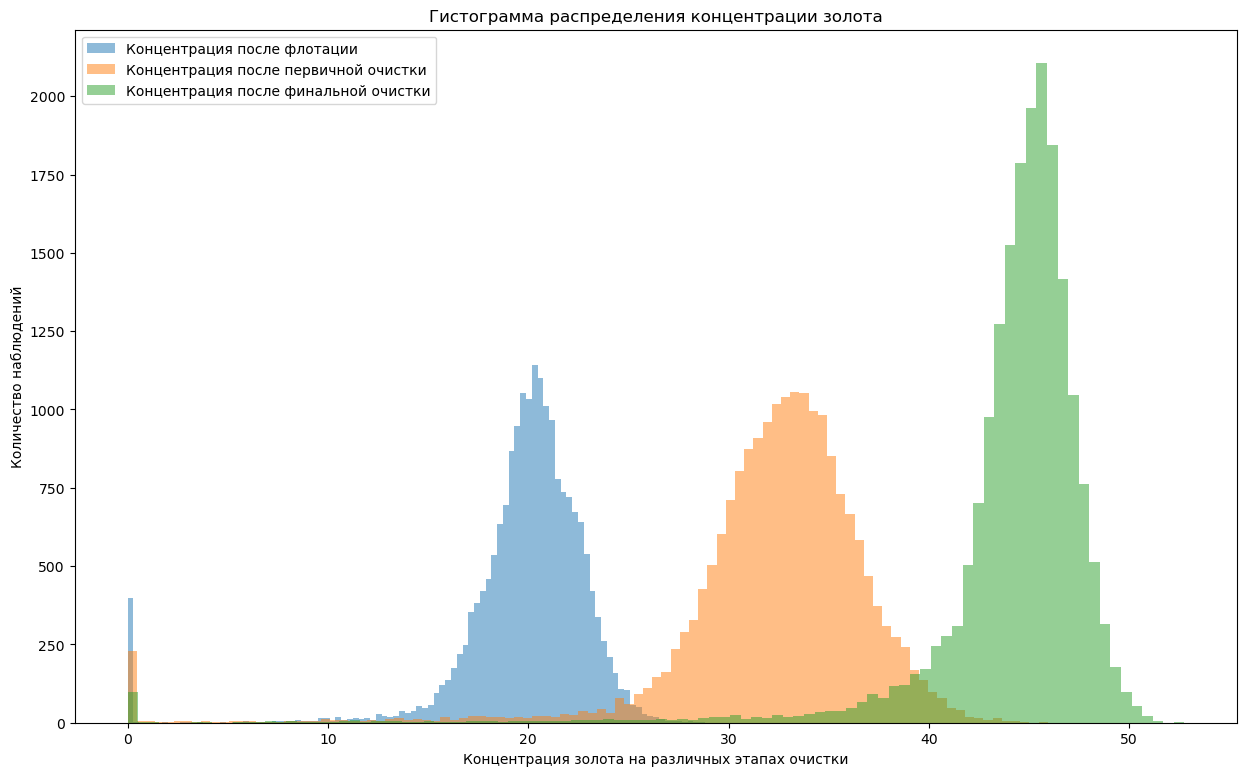

In [13]:
plt.figure(figsize=[15,9])
plt.hist(full['rougher.output.concentrate_au'], bins=100, label='Концентрация после флотации', alpha=.5)
plt.hist(full['primary_cleaner.output.concentrate_au'], bins=100, label='Концентрация после первичной очистки', alpha=.5)
plt.hist(full['final.output.concentrate_au'], bins=100, label='Концентрация после финальной очистки', alpha=.5)
plt.xlabel('Концентрация золота на различных этапах очистки')
plt.ylabel('Количество наблюдений')
plt.title("Гистограмма распределения концентрации золота")
plt.legend()
plt.show();

Концентрация золота увеличивается после каждого этапа очистки.

*Серебро*

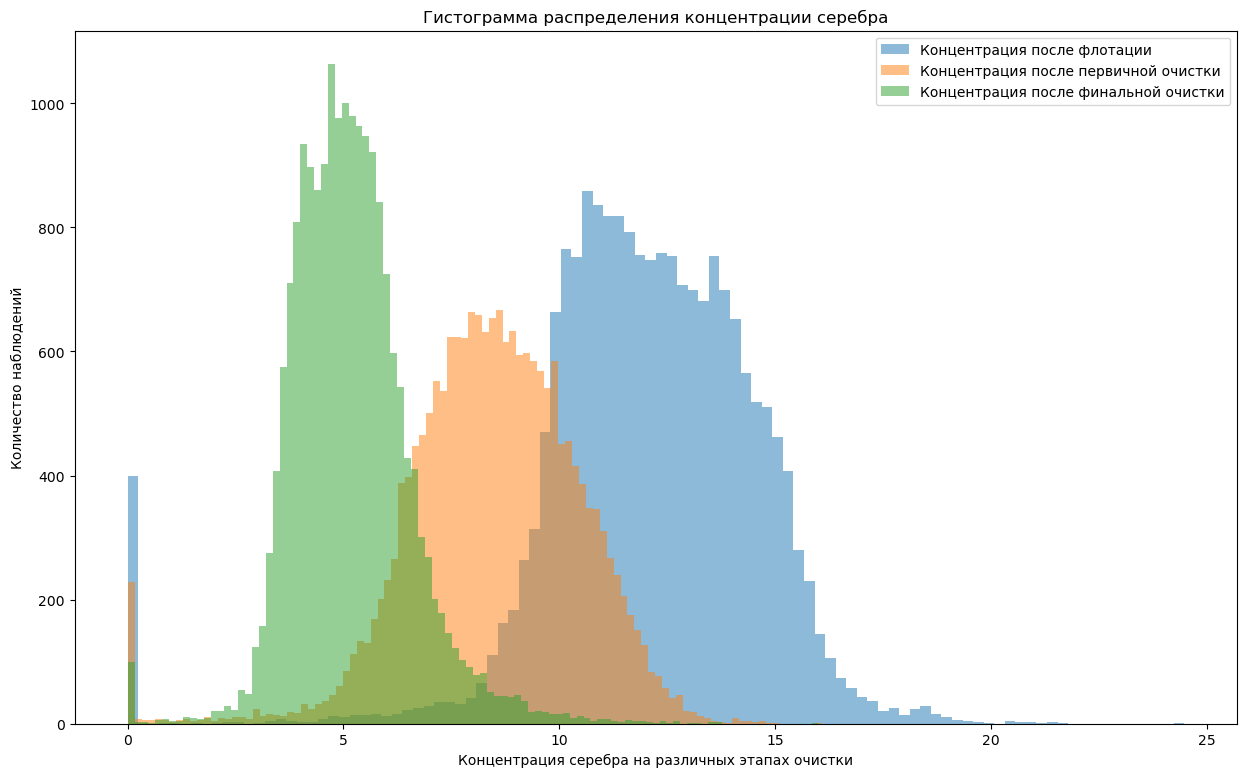

In [14]:
plt.figure(figsize=[15,9])
plt.hist(full['rougher.output.concentrate_ag'], bins=100, label='Концентрация после флотации', alpha=.5)
plt.hist(full['primary_cleaner.output.concentrate_ag'], bins=100, label='Концентрация после первичной очистки', alpha=.5)
plt.hist(full['final.output.concentrate_ag'], bins=100, label='Концентрация после финальной очистки', alpha=.5)
plt.xlabel('Концентрация серебра на различных этапах очистки')
plt.ylabel('Количество наблюдений')
plt.title("Гистограмма распределения концентрации серебра")
plt.legend()
plt.show();

Концентрация серебра, наоборот, понижается после каждого этапа очистки (видимо, происходит фильтрация).

*Свинец*

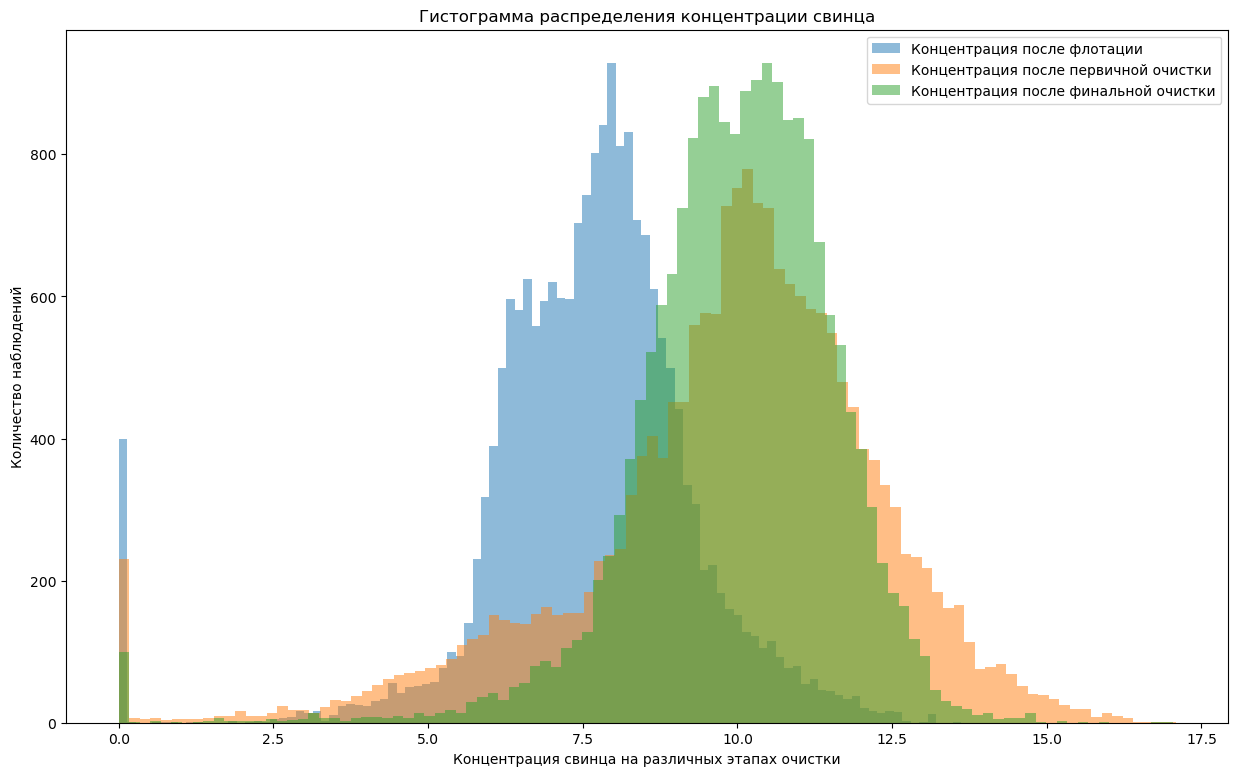

In [15]:
plt.figure(figsize=[15,9])
plt.hist(full['rougher.output.concentrate_pb'], bins=100, label='Концентрация после флотации', alpha=.5)
plt.hist(full['primary_cleaner.output.concentrate_pb'], bins=100, label='Концентрация после первичной очистки', alpha=.5)
plt.hist(full['final.output.concentrate_pb'], bins=100, label='Концентрация после финальной очистки', alpha=.5)
plt.xlabel('Концентрация свинца на различных этапах очистки')
plt.ylabel('Количество наблюдений')
plt.title("Гистограмма распределения концентрации свинца")
plt.legend()
plt.show();

Концентрация свинца возрастает после первого этапа, а затем изменяется незначительно.

**2.2 Сравнение распределений размеров гранул сырья на обучающей и тестовых выборках**

*Этап флотации*

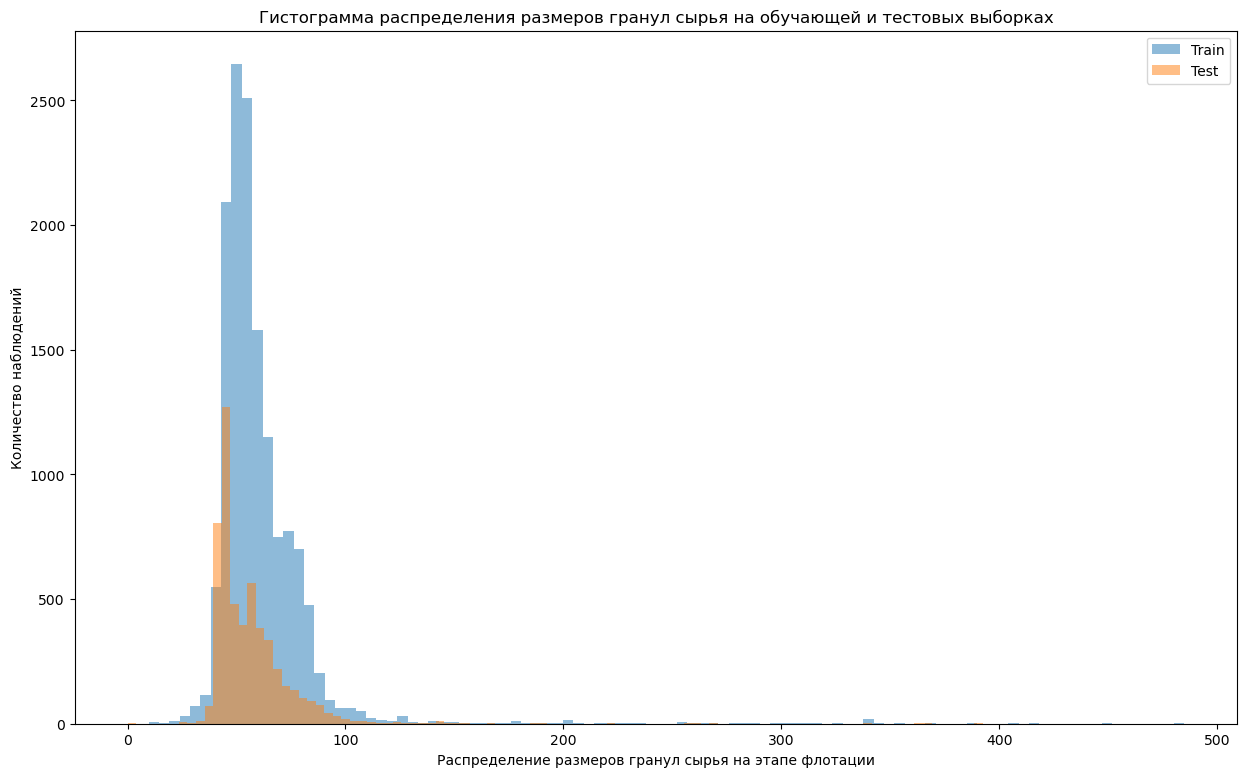

In [16]:
plt.figure(figsize=[15,9])
plt.hist(train['rougher.input.feed_size'], bins=100, label='Train', alpha=.5)
plt.hist(test['rougher.input.feed_size'], bins=100, label='Test', alpha=.5)
plt.xlabel('Распределение размеров гранул сырья на этапе флотации')
plt.ylabel('Количество наблюдений')
plt.title("Гистограмма распределения размеров гранул сырья на обучающей и тестовых выборках")
plt.legend()
plt.show();

Распределние размеров гранул сырья на этапе флотации на тестовой и тренировочной выборках более-менее схожи. В обеих выборках есть выборосы. 

*Первичная очистка*

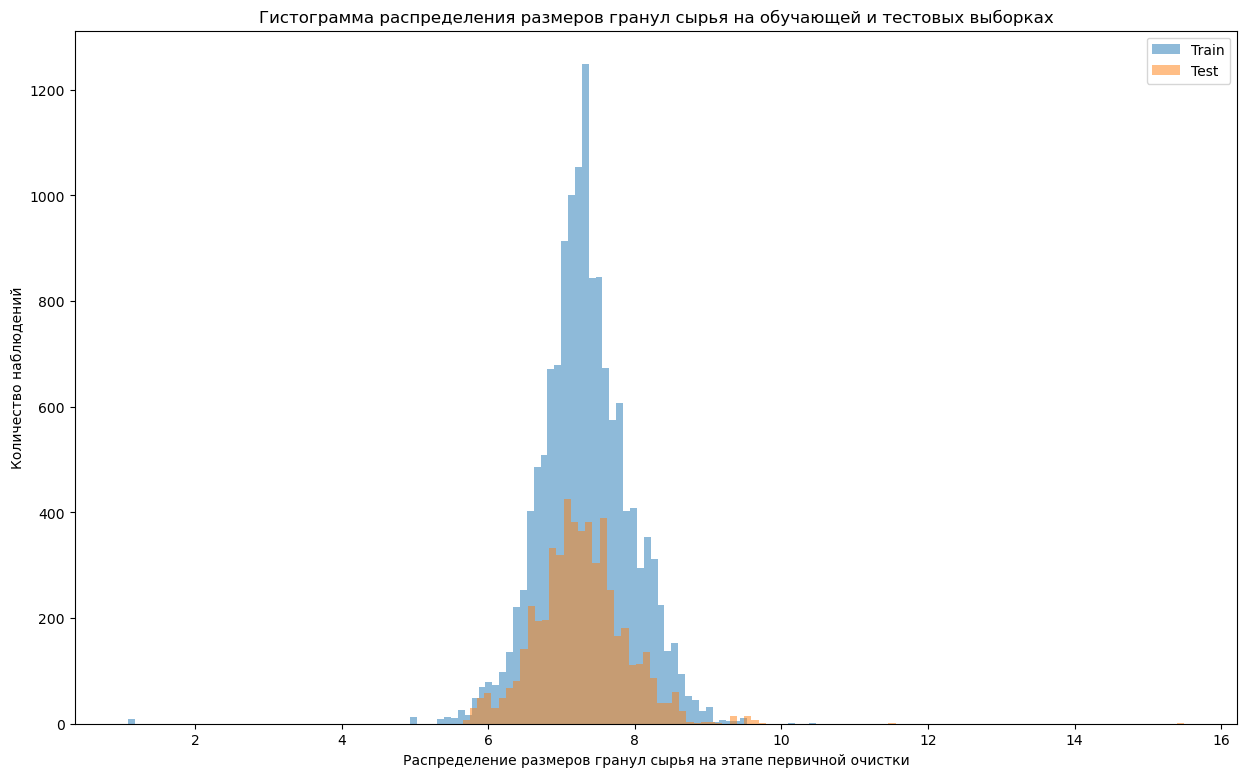

In [17]:
plt.figure(figsize=[15,9])
plt.hist(train['primary_cleaner.input.feed_size'], bins=100, label='Train', alpha=.5)
plt.hist(test['primary_cleaner.input.feed_size'], bins=100, label='Test', alpha=.5)
plt.xlabel('Распределение размеров гранул сырья на этапе первичной очистки')
plt.ylabel('Количество наблюдений')
plt.title("Гистограмма распределения размеров гранул сырья на обучающей и тестовых выборках")
plt.legend()
plt.show();

Размеры гранул на этапе первичной очистки распределены примерно одинаково на двух выборках

**2.3 Исследование суммарной концентрации всех веществ на разных стадиях**

In [18]:
full['rougher_sum'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol']
full['primary_cleaner_sum'] = full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol']
full['final_sum'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_sol']

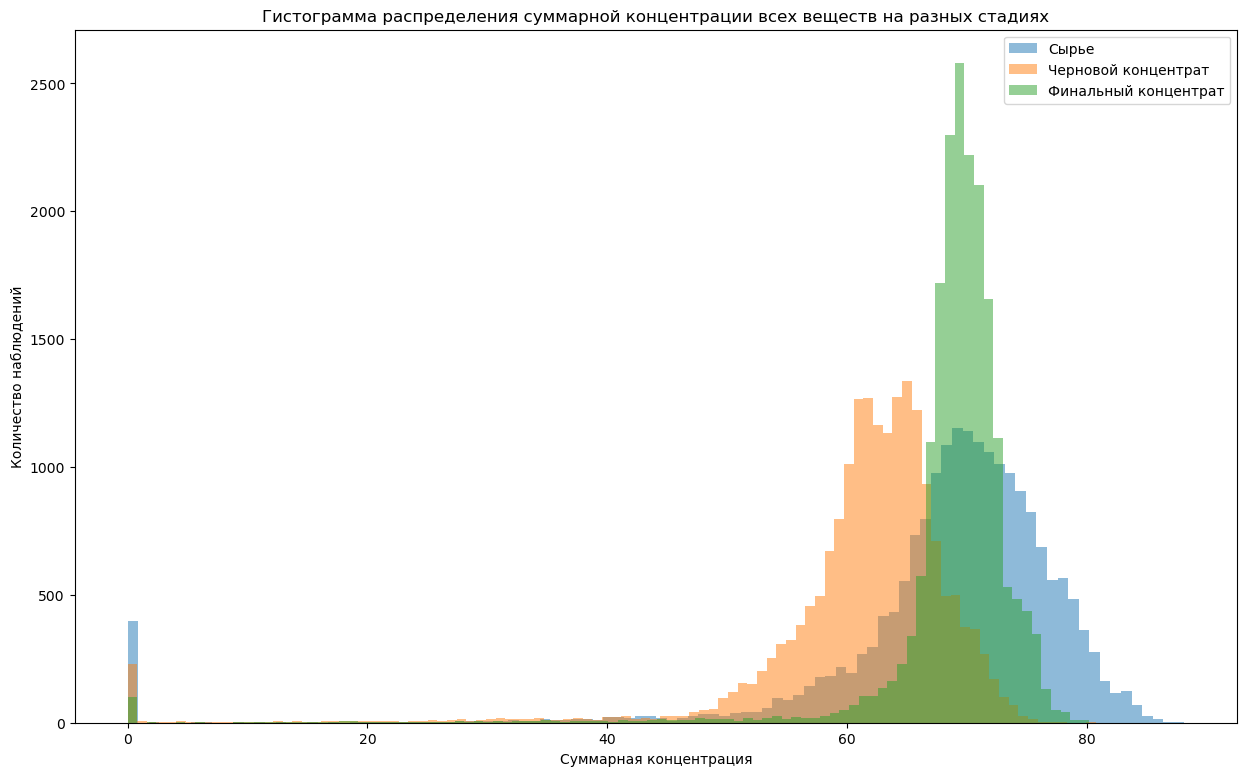

In [19]:
plt.figure(figsize=[15,9])
plt.hist(full['rougher_sum'], bins=100, label='Сырье', alpha=.5)
plt.hist(full['primary_cleaner_sum'], bins=100, label='Черновой концентрат', alpha=.5)
plt.hist(full['final_sum'], bins=100, label='Финальный концентрат', alpha=.5)
plt.xlabel('Суммарная концентрация')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения суммарной концентрации всех веществ на разных стадиях')
plt.legend()
plt.show();

После флотации суммарная концентрация всех веществ снижается, а после получения чернового концентрата снова возрастает.

Во всех распределениях присутствует аномальный пик около нулевого значения. 

In [20]:
train = train[(train['rougher.output.concentrate_ag']>0)&(train['rougher.output.concentrate_au']>0)&(train['rougher.output.concentrate_pb']>0)&(train['rougher.output.concentrate_sol']>0)]
train = train[(train['primary_cleaner.output.concentrate_ag']>0)&(train['primary_cleaner.output.concentrate_au']>0)&(train['primary_cleaner.output.concentrate_pb']>0)&(train['primary_cleaner.output.concentrate_sol']>0)]
train = train[(train['final.output.concentrate_ag']>0)&(train['final.output.concentrate_au']>0)&(train['final.output.concentrate_pb']>0)&(train['final.output.concentrate_sol']>0)]

In [21]:
test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

## Модель

**3.1 Функция для вычисления итоговой sMAPE**

In [22]:
def smape(y_true, y_pred):
    er = np.mean(np.abs(y_true - y_pred)/((np.abs(y_true)+np.abs(y_pred))/2))*100
    return er

In [23]:
my_score = make_scorer(smape, greater_is_better=False)

In [24]:
def final_smape(smape_rougher, smape_final):
    return (0.25*smape_rougher + 0.75*smape_final)

**3.2 Обучение моделей**

In [25]:
features = test.columns.values
features_train = train[features].reset_index(drop=True)
features_train = features_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_train_rougher = train['rougher.output.recovery'].reset_index(drop=True)                       
target_train_final = train['final.output.recovery'].reset_index(drop=True)

features_test = test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).reset_index(drop=True)
target_test_rougher = test['rougher.output.recovery'].reset_index(drop=True)                       
target_test_final = test['final.output.recovery'].reset_index(drop=True)

***DecisionTreeRegressor***

*1) для чернового концентрата*

In [26]:
dtr_rougher = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': list(range(1, 20))}
CV_dtr_rougher = GridSearchCV(estimator=dtr_rougher, param_grid=parameters, cv=5, scoring=my_score)
CV_dtr_rougher.fit(features_train, target_train_rougher)
CV_dtr_rougher_best_par = CV_dtr_rougher.best_params_
CV_dtr_rougher_best_score = CV_dtr_rougher.best_score_
print(CV_dtr_rougher_best_par, 'sMAPE=', CV_dtr_rougher_best_score*(-1))

{'max_depth': 4} sMAPE= 7.316661884341523


*2) для финального концентрата*

In [27]:
dtr_final = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': list(range(1, 20))}
CV_dtr_final = GridSearchCV(estimator=dtr_final, param_grid=parameters, cv=5, scoring=my_score)
CV_dtr_final.fit(features_train, target_train_final)
CV_dtr_final_best_par = CV_dtr_final.best_params_
CV_dtr_final_best_score = CV_dtr_final.best_score_
print(CV_dtr_final_best_par, 'sMAPE=', CV_dtr_final_best_score*(-1))

{'max_depth': 3} sMAPE= 9.418711833416845


In [28]:
drt_final_smape = final_smape(CV_dtr_rougher_best_score, CV_dtr_final_best_score)
drt_final_smape*(-1)

8.893199346148014

***RandomForestRegressor***

*1) для чернового концентрата*

In [29]:
rfr_rougher = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth': list(range(1, 7))
}
CV_rfr_rougher = GridSearchCV(estimator=rfr_rougher, param_grid=parameters, n_jobs=-1, cv=5, scoring=my_score)
CV_rfr_rougher.fit(features_train, target_train_rougher)
CV_rfr_rougher_best_par = CV_rfr_rougher.best_params_
CV_rfr_rougher_best_score = CV_rfr_rougher.best_score_
print(CV_rfr_rougher_best_par, 'sMAPE=', CV_rfr_rougher_best_score*(-1))

{'max_depth': 4, 'n_estimators': 10} sMAPE= 6.5275435687715895


*2) для финального концентрата*

In [30]:
rfr_final = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth': list(range(1, 7))
}
CV_rfr_final = GridSearchCV(estimator=rfr_final, param_grid=parameters, n_jobs=-1, cv=5, scoring=my_score)
CV_rfr_final.fit(features_train, target_train_final)
CV_rfr_final_best_par = CV_rfr_final.best_params_
CV_rfr_final_best_score = CV_rfr_final.best_score_
print(CV_rfr_final_best_par, 'sMAPE=', CV_rfr_final_best_score*(-1))

{'max_depth': 4, 'n_estimators': 40} sMAPE= 9.009002569419511


In [32]:
rfr_final_smape = final_smape(CV_rfr_rougher_best_score, CV_rfr_final_best_score)
rfr_final_smape*(-1)

8.38863781925753

Лучший итоговый показатель sMAPE получился у модели RandomForestRegressor. 

Проверим модель на тестовой выборке.

In [33]:
predictions_test_rougher = CV_rfr_rougher.predict(features_test)
predictions_test_final = CV_rfr_final.predict(features_test)
smape_test_rougher = smape(target_test_rougher, predictions_test_rougher)
smape_test_final = smape(target_test_final, predictions_test_rougher)
test_final_smape = final_smape(smape_test_rougher, smape_test_final)
test_final_smape

19.870722242151484

Проверим модели на адекватность с помощью DummyRegressor

In [34]:
dummy_rougher = DummyRegressor(strategy="mean")
dummy_rougher.fit(features_train, target_train_rougher)
predictions_dummy_rougher = dummy_rougher.predict(features_test)
dummy_rougher_smape = smape(target_test_rougher, predictions_dummy_rougher)

dummy_final = DummyRegressor(strategy="mean")
dummy_final.fit(features_train, target_train_final)
predictions_dummy_final = dummy_final.predict(features_test)
dummy_final_smape = smape(target_test_final, predictions_dummy_final)

dummy_smape = final_smape(dummy_rougher_smape, dummy_final_smape)
dummy_smape

9.82761382259758